# Graph embedding using [DeepWalk](https://arxiv.org/pdf/1403.6652.pdf) and[ node2vec](https://cs.stanford.edu/~jure/pubs/node2vec-kdd16.pdf)

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import networkx as nx
from copy import deepcopy

from sklearn.decomposition import PCA

from graph_embedding_continuity import *

In [2]:
N = 20
# Barabasi-Albert parameter
m = 5
# number of edge(s) to remove
k_remove = 1

N_TRAIN = 100
EMBEDDING_SIZE = 4
WALK_LENGTH = 10
WINDOW_SIZE = 2
N_NEG = 2
HIDDEN_SIZE = 16

USE_CUDA = False

## Embedding under removal of an edge (while keeping the graph connected)

In [3]:
# generate a random graph
G = nx.barabasi_albert_graph(N, m)

# add some random weights on each edge    
for u, v, d in G.edges(data=True):
    d['weight'] = np.random.rand()
    
# save layout
pos = nx.spring_layout(G)

# create a new graph with one edge randomly removed
G_removed = remove_random_edges(G, k=k_remove, in_place=False)

### DeepWalk

Epoch : 1/100: 100%|██████████████████████████████████| 20.0/20.0 [00:00<00:00, 39.0it/s, loss=51.2]
Epoch : 10/100: 100%|███████████████████████████████████| 20.0/20.0 [00:00<00:00, 40.3it/s, loss=51]
Epoch : 20/100: 100%|█████████████████████████████████| 20.0/20.0 [00:00<00:00, 37.9it/s, loss=50.1]
Epoch : 30/100: 100%|█████████████████████████████████| 20.0/20.0 [00:00<00:00, 41.2it/s, loss=47.6]
Epoch : 40/100: 100%|█████████████████████████████████| 20.0/20.0 [00:00<00:00, 41.2it/s, loss=46.9]
Epoch : 50/100: 100%|█████████████████████████████████| 20.0/20.0 [00:00<00:00, 38.6it/s, loss=45.3]
Epoch : 60/100: 100%|█████████████████████████████████| 20.0/20.0 [00:00<00:00, 41.3it/s, loss=44.7]
Epoch : 70/100: 100%|█████████████████████████████████| 20.0/20.0 [00:00<00:00, 39.5it/s, loss=44.6]
Epoch : 80/100: 100%|█████████████████████████████████| 20.0/20.0 [00:00<00:00, 42.2it/s, loss=44.8]
Epoch : 90/100: 100%|█████████████████████████████████| 20.0/20.0 [00:00<00:00, 40.4it/s, l

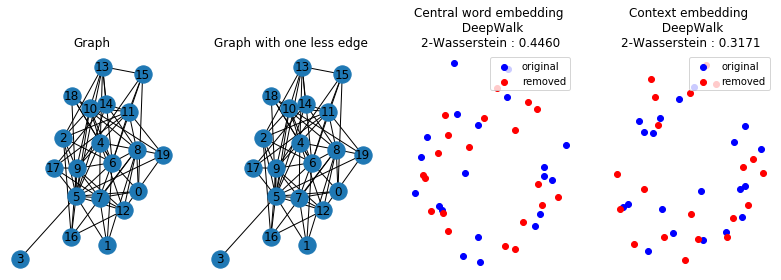

In [4]:
emb_word, emb_context = deepwalk_embedding(G,
                                           k=EMBEDDING_SIZE,
                                           n_train=N_TRAIN,
                                           walk_length=WALK_LENGTH,
                                           window_size=WINDOW_SIZE,
                                           n_neg=N_NEG,
                                           hidden_size = HIDDEN_SIZE,
                                           use_cuda=USE_CUDA,
                                          )
emb_removed_word, emb_removed_context = deepwalk_embedding(G_removed,
                                                           k=EMBEDDING_SIZE,
                                                           n_train=N_TRAIN,
                                                           walk_length=WALK_LENGTH,
                                                           window_size=WINDOW_SIZE,
                                                           n_neg=N_NEG,
                                                           hidden_size = HIDDEN_SIZE,
                                                           use_cuda=USE_CUDA,
                                                          )

# extract 2 principal components to plot
pca = PCA(n_components=2)
emb_word = pca.fit_transform(emb_word.cpu())
emb_context = pca.fit_transform(emb_context.cpu())
emb_removed_word = pca.fit_transform(emb_removed_word.cpu())
emb_removed_context = pca.fit_transform(emb_removed_context.cpu())

# plot the graph
fig, axes = plt.subplots(figsize=(11,4), nrows=1, ncols=4)

ax = axes[0]
nx.draw_networkx(G, pos = pos, ax=ax)
ax.set_title('Graph')
ax.axis('off')

ax = axes[1]
nx.draw_networkx(G_removed, pos = pos, ax=ax)
ax.set_title('Graph with one less edge')
ax.axis('off')

wass_word = wasserstein_metric(emb_word, emb_removed_word)
wass_context = wasserstein_metric(emb_context, emb_removed_context)

ax = axes[2]
ax.scatter(emb_word[:, 0], emb_word[:, 1], label='original', color='b')
ax.scatter(emb_removed_word[:, 0], emb_removed_word[:, 1], label='removed', color='r')
ax.set_title('Central word embedding \n DeepWalk\n2-Wasserstein : {:.4f}'.format(wass_word))
ax.legend(loc='upper right')
ax.axis('off')

ax = axes[3]
ax.scatter(emb_context[:, 0], emb_context[:, 1], label='original', color='b')
ax.scatter(emb_removed_context[:, 0], emb_removed_context[:, 1], label='removed', color='r')
ax.set_title('Context embedding \n DeepWalk\n2-Wasserstein : {:.4f}'.format(wass_context))
ax.legend(loc='upper right')
ax.axis('off')

plt.tight_layout()
plt.show()

### node2vec - depth-first incentive

Epoch : 1/100: 100%|██████████████████████████████████| 20.0/20.0 [00:00<00:00, 39.8it/s, loss=51.3]
Epoch : 10/100: 100%|█████████████████████████████████| 20.0/20.0 [00:00<00:00, 40.6it/s, loss=50.9]
Epoch : 20/100: 100%|█████████████████████████████████| 20.0/20.0 [00:00<00:00, 39.9it/s, loss=49.8]
Epoch : 30/100: 100%|█████████████████████████████████| 20.0/20.0 [00:00<00:00, 39.4it/s, loss=47.3]
Epoch : 40/100: 100%|█████████████████████████████████| 20.0/20.0 [00:00<00:00, 40.2it/s, loss=46.2]
Epoch : 50/100: 100%|█████████████████████████████████| 20.0/20.0 [00:00<00:00, 40.9it/s, loss=47.2]
Epoch : 60/100: 100%|█████████████████████████████████| 20.0/20.0 [00:00<00:00, 39.9it/s, loss=46.6]
Epoch : 70/100: 100%|█████████████████████████████████| 20.0/20.0 [00:00<00:00, 40.0it/s, loss=46.5]
Epoch : 80/100: 100%|█████████████████████████████████| 20.0/20.0 [00:00<00:00, 40.7it/s, loss=45.3]
Epoch : 90/100: 100%|█████████████████████████████████| 20.0/20.0 [00:00<00:00, 38.0it/s, l

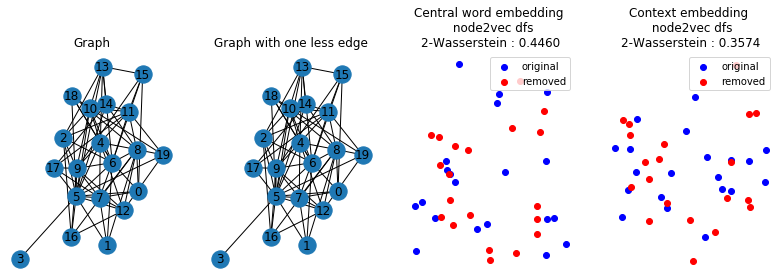

In [5]:
p = 2.0
q = 0.5

emb_word, emb_context = node2vec_embedding(G,
                                           p=p,
                                           q=q,
                                           k=EMBEDDING_SIZE,
                                           n_train=N_TRAIN,
                                           walk_length=WALK_LENGTH,
                                           window_size=WINDOW_SIZE,
                                           n_neg=N_NEG,
                                           hidden_size = HIDDEN_SIZE,
                                           use_cuda=USE_CUDA,
                                          )
emb_removed_word, emb_removed_context = node2vec_embedding(G_removed,
                                                           p=p,
                                                           q=q,
                                                           k=EMBEDDING_SIZE,
                                                           n_train=N_TRAIN,
                                                           walk_length=WALK_LENGTH,
                                                           window_size=WINDOW_SIZE,
                                                           n_neg=N_NEG,
                                                           hidden_size = HIDDEN_SIZE,
                                                           use_cuda=USE_CUDA,
                                                          )

# extract 2 principal components to plot
pca = PCA(n_components=2)
emb_word = pca.fit_transform(emb_word.cpu())
emb_context = pca.fit_transform(emb_context.cpu())
emb_removed_word = pca.fit_transform(emb_removed_word.cpu())
emb_removed_context = pca.fit_transform(emb_removed_context.cpu())

# plot the graph
fig, axes = plt.subplots(figsize=(11,4), nrows=1, ncols=4)

ax = axes[0]
nx.draw_networkx(G, pos = pos, ax=ax)
ax.set_title('Graph')
ax.axis('off')

ax = axes[1]
nx.draw_networkx(G_removed, pos = pos, ax=ax)
ax.set_title('Graph with one less edge')
ax.axis('off')

ax = axes[2]
ax.scatter(emb_word[:, 0], emb_word[:, 1], label='original', color='b')
ax.scatter(emb_removed_word[:, 0], emb_removed_word[:, 1], label='removed', color='r')
ax.set_title('Central word embedding \n node2vec dfs\n2-Wasserstein : {:.4f}'.format(wass_word))
ax.legend(loc='upper right')
ax.axis('off')

wass_word = wasserstein_metric(emb_word, emb_removed_word)
wass_context = wasserstein_metric(emb_context, emb_removed_context)

ax = axes[3]
ax.scatter(emb_context[:, 0], emb_context[:, 1], label='original', color='b')
ax.scatter(emb_removed_context[:, 0], emb_removed_context[:, 1], label='removed', color='r')
ax.set_title('Context embedding \n node2vec dfs\n2-Wasserstein : {:.4f}'.format(wass_context))
ax.legend(loc='upper right')
ax.axis('off')

plt.tight_layout()
plt.show()

### node2vec - breadth-first incentive

Epoch : 1/100: 100%|██████████████████████████████████| 20.0/20.0 [00:00<00:00, 40.3it/s, loss=51.4]
Epoch : 10/100: 100%|███████████████████████████████████| 20.0/20.0 [00:00<00:00, 40.7it/s, loss=51]
Epoch : 20/100: 100%|█████████████████████████████████| 20.0/20.0 [00:00<00:00, 39.7it/s, loss=50.6]
Epoch : 30/100: 100%|█████████████████████████████████| 20.0/20.0 [00:00<00:00, 39.6it/s, loss=48.7]
Epoch : 40/100: 100%|█████████████████████████████████| 20.0/20.0 [00:00<00:00, 41.3it/s, loss=47.1]
Epoch : 50/100: 100%|█████████████████████████████████| 20.0/20.0 [00:00<00:00, 39.6it/s, loss=47.3]
Epoch : 60/100: 100%|█████████████████████████████████| 20.0/20.0 [00:00<00:00, 40.4it/s, loss=46.8]
Epoch : 70/100: 100%|█████████████████████████████████| 20.0/20.0 [00:00<00:00, 39.7it/s, loss=44.2]
Epoch : 80/100: 100%|█████████████████████████████████| 20.0/20.0 [00:00<00:00, 37.9it/s, loss=44.8]
Epoch : 90/100: 100%|█████████████████████████████████| 20.0/20.0 [00:00<00:00, 39.3it/s, l

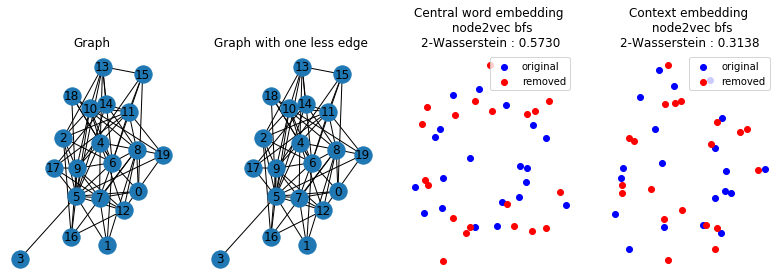

In [6]:
p = 0.5
q = 2.0

emb_word, emb_context = node2vec_embedding(G,
                                           p=p,
                                           q=q,
                                           k=EMBEDDING_SIZE,
                                           n_train=N_TRAIN,
                                           walk_length=WALK_LENGTH,
                                           window_size=WINDOW_SIZE,
                                           n_neg=N_NEG,
                                           hidden_size = HIDDEN_SIZE,
                                           use_cuda=USE_CUDA,
                                          )
emb_removed_word, emb_removed_context = node2vec_embedding(G_removed,
                                                           p=p,
                                                           q=q,
                                                           k=EMBEDDING_SIZE,
                                                           n_train=N_TRAIN,
                                                           walk_length=WALK_LENGTH,
                                                           window_size=WINDOW_SIZE,
                                                           n_neg=N_NEG,
                                                           hidden_size = HIDDEN_SIZE,
                                                           use_cuda=USE_CUDA,
                                                          )

# extract 2 principal components to plot
pca = PCA(n_components=2)
emb_word = pca.fit_transform(emb_word.cpu())
emb_context = pca.fit_transform(emb_context.cpu())
emb_removed_word = pca.fit_transform(emb_removed_word.cpu())
emb_removed_context = pca.fit_transform(emb_removed_context.cpu())

# plot the graph
fig, axes = plt.subplots(figsize=(11,4), nrows=1, ncols=4)

ax = axes[0]
nx.draw_networkx(G, pos = pos, ax=ax)
ax.set_title('Graph')
ax.axis('off')

ax = axes[1]
nx.draw_networkx(G_removed, pos = pos, ax=ax)
ax.set_title('Graph with one less edge')
ax.axis('off')

wass_word = wasserstein_metric(emb_word, emb_removed_word)
wass_context = wasserstein_metric(emb_context, emb_removed_context)

ax = axes[2]
ax.scatter(emb_word[:, 0], emb_word[:, 1], label='original', color='b')
ax.scatter(emb_removed_word[:, 0], emb_removed_word[:, 1], label='removed', color='r')
ax.set_title('Central word embedding \n node2vec bfs\n2-Wasserstein : {:.4f}'.format(wass_word))
ax.legend(loc='upper right')
ax.axis('off')

ax = axes[3]
ax.scatter(emb_context[:, 0], emb_context[:, 1], label='original', color='b')
ax.scatter(emb_removed_context[:, 0], emb_removed_context[:, 1], label='removed', color='r')
ax.set_title('Context embedding \n node2vec bfs\n2-Wasserstein : {:.4f}'.format(wass_context))
ax.legend(loc='upper right')
ax.axis('off')

plt.tight_layout()
plt.show()

## Embedding under removal of an edge that disconnects the graph

In [7]:
# generate a random graph that bridges to clusters
G1 = nx.barabasi_albert_graph(N, 2)
G2 = nx.barabasi_albert_graph(N, 2)

# relabel nodes of G2
d = {}
for v in G1.nodes:
    d[v] = N+v
G2 = nx.relabel_nodes(G2, d)

G = nx.union(G1, G2)

G.add_edge(N-1, N)
# add some random weights on each edge
for _, _, d in G.edges(data=True):
    d['weight'] = np.random.rand()
    
# save layout
pos = nx.spring_layout(G)

# create a new graph by removing the bridge edge, resulting in a disconnected graph
G_removed = deepcopy(G)
G_removed.remove_edge(N-1, N)

### DeepWalk

Epoch : 1/100: 100%|██████████████████████████████████| 40.0/40.0 [00:00<00:00, 41.1it/s, loss=51.3]
Epoch : 10/100: 100%|█████████████████████████████████| 40.0/40.0 [00:00<00:00, 41.6it/s, loss=49.2]
Epoch : 20/100: 100%|███████████████████████████████████| 40.0/40.0 [00:00<00:00, 40.7it/s, loss=37]
Epoch : 30/100: 100%|█████████████████████████████████| 40.0/40.0 [00:00<00:00, 41.8it/s, loss=36.7]
Epoch : 40/100: 100%|█████████████████████████████████| 40.0/40.0 [00:00<00:00, 40.8it/s, loss=35.5]
Epoch : 50/100: 100%|█████████████████████████████████| 40.0/40.0 [00:00<00:00, 41.5it/s, loss=35.6]
Epoch : 60/100: 100%|█████████████████████████████████| 40.0/40.0 [00:00<00:00, 40.7it/s, loss=34.8]
Epoch : 70/100: 100%|█████████████████████████████████| 40.0/40.0 [00:00<00:00, 40.6it/s, loss=32.7]
Epoch : 80/100: 100%|█████████████████████████████████| 40.0/40.0 [00:00<00:00, 40.9it/s, loss=32.6]
Epoch : 90/100: 100%|█████████████████████████████████| 40.0/40.0 [00:00<00:00, 41.5it/s, l

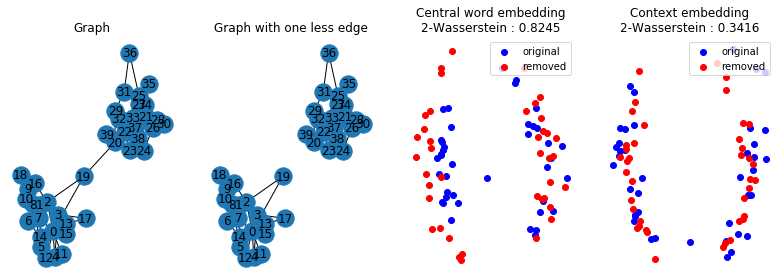

In [8]:
emb_word, emb_context = deepwalk_embedding(G,
                                           k=EMBEDDING_SIZE,
                                           n_train=N_TRAIN,
                                           walk_length=WALK_LENGTH,
                                           window_size=WINDOW_SIZE,
                                           n_neg=N_NEG,
                                           hidden_size = HIDDEN_SIZE,
                                           use_cuda=USE_CUDA,
                                          )
emb_removed_word, emb_removed_context = deepwalk_embedding(G_removed,
                                                           k=EMBEDDING_SIZE,
                                                           n_train=N_TRAIN,
                                                           walk_length=WALK_LENGTH,
                                                           window_size=WINDOW_SIZE,
                                                           n_neg=N_NEG,
                                                           hidden_size = HIDDEN_SIZE,
                                                           use_cuda=USE_CUDA,
                                                          )

# extract 2 principal components to plot
pca = PCA(n_components=2)
emb_word = pca.fit_transform(emb_word.cpu())
emb_context = pca.fit_transform(emb_context.cpu())
emb_removed_word = pca.fit_transform(emb_removed_word.cpu())
emb_removed_context = pca.fit_transform(emb_removed_context.cpu())

# plot the graph
fig, axes = plt.subplots(figsize=(11,4), nrows=1, ncols=4)

ax = axes[0]
nx.draw_networkx(G, pos = pos, ax=ax)
ax.set_title('Graph')
ax.axis('off')

ax = axes[1]
nx.draw_networkx(G_removed, pos = pos, ax=ax)
ax.set_title('Graph with one less edge')
ax.axis('off')

wass_word = wasserstein_metric(emb_word, emb_removed_word)
wass_context = wasserstein_metric(emb_context, emb_removed_context)

ax = axes[2]
ax.scatter(emb_word[:, 0], emb_word[:, 1], label='original', color='b')
ax.scatter(emb_removed_word[:, 0], emb_removed_word[:, 1], label='removed', color='r')
ax.set_title('Central word embedding\n2-Wasserstein : {:.4f}'.format(wass_word))
ax.legend(loc='upper right')
ax.axis('off')

ax = axes[3]
ax.scatter(emb_context[:, 0], emb_context[:, 1], label='original', color='b')
ax.scatter(emb_removed_context[:, 0], emb_removed_context[:, 1], label='removed', color='r')
ax.set_title('Context embedding\n2-Wasserstein : {:.4f}'.format(wass_context))
ax.legend(loc='upper right')
ax.axis('off')

plt.tight_layout()
plt.show()

### node2vec -  depth-first incentive

Epoch : 1/100: 100%|██████████████████████████████████| 40.0/40.0 [00:01<00:00, 39.1it/s, loss=51.5]
Epoch : 10/100: 100%|█████████████████████████████████| 40.0/40.0 [00:00<00:00, 40.3it/s, loss=50.7]
Epoch : 20/100: 100%|█████████████████████████████████| 40.0/40.0 [00:00<00:00, 40.1it/s, loss=40.8]
Epoch : 30/100: 100%|███████████████████████████████████| 40.0/40.0 [00:00<00:00, 40.8it/s, loss=32]
Epoch : 40/100: 100%|█████████████████████████████████| 40.0/40.0 [00:00<00:00, 40.1it/s, loss=31.9]
Epoch : 50/100: 100%|███████████████████████████████████| 40.0/40.0 [00:00<00:00, 40.2it/s, loss=31]
Epoch : 60/100: 100%|█████████████████████████████████| 40.0/40.0 [00:00<00:00, 40.2it/s, loss=30.2]
Epoch : 70/100: 100%|█████████████████████████████████| 40.0/40.0 [00:00<00:00, 40.6it/s, loss=30.5]
Epoch : 80/100: 100%|█████████████████████████████████| 40.0/40.0 [00:01<00:00, 39.7it/s, loss=29.2]
Epoch : 90/100: 100%|█████████████████████████████████| 40.0/40.0 [00:00<00:00, 42.5it/s, l

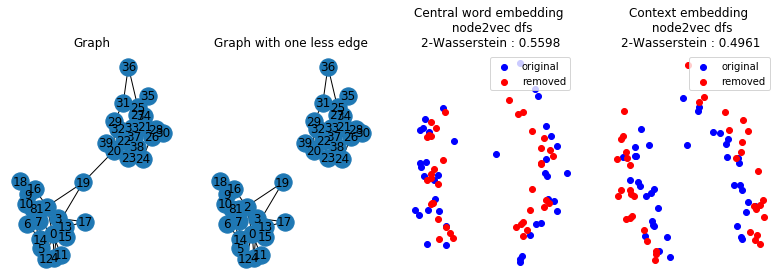

In [9]:
p = 2.0
q = 0.5

emb_word, emb_context = node2vec_embedding(G,
                                           p=p,
                                           q=q,
                                           k=EMBEDDING_SIZE,
                                           n_train=N_TRAIN,
                                           walk_length=WALK_LENGTH,
                                           window_size=WINDOW_SIZE,
                                           n_neg=N_NEG,
                                           hidden_size = HIDDEN_SIZE,
                                           use_cuda=USE_CUDA,
                                          )
emb_removed_word, emb_removed_context = node2vec_embedding(G_removed,
                                                           p=p,
                                                           q=q,
                                                           k=EMBEDDING_SIZE,
                                                           n_train=N_TRAIN,
                                                           walk_length=WALK_LENGTH,
                                                           window_size=WINDOW_SIZE,
                                                           n_neg=N_NEG,
                                                           hidden_size = HIDDEN_SIZE,
                                                           use_cuda=USE_CUDA,
                                                          )

# extract 2 principal components to plot
pca = PCA(n_components=2)
emb_word = pca.fit_transform(emb_word.cpu())
emb_context = pca.fit_transform(emb_context.cpu())
emb_removed_word = pca.fit_transform(emb_removed_word.cpu())
emb_removed_context = pca.fit_transform(emb_removed_context.cpu())

# plot the graph
fig, axes = plt.subplots(figsize=(11,4), nrows=1, ncols=4)

ax = axes[0]
nx.draw_networkx(G, pos = pos, ax=ax)
ax.set_title('Graph')
ax.axis('off')

ax = axes[1]
nx.draw_networkx(G_removed, pos = pos, ax=ax)
ax.set_title('Graph with one less edge')
ax.axis('off')

wass_word = wasserstein_metric(emb_word, emb_removed_word)
wass_context = wasserstein_metric(emb_context, emb_removed_context)

ax = axes[2]
ax.scatter(emb_word[:, 0], emb_word[:, 1], label='original', color='b')
ax.scatter(emb_removed_word[:, 0], emb_removed_word[:, 1], label='removed', color='r')
ax.set_title('Central word embedding \n node2vec dfs\n2-Wasserstein : {:.4f}'.format(wass_word))
ax.legend(loc='upper right')
ax.axis('off')

ax = axes[3]
ax.scatter(emb_context[:, 0], emb_context[:, 1], label='original', color='b')
ax.scatter(emb_removed_context[:, 0], emb_removed_context[:, 1], label='removed', color='r')
ax.set_title('Context embedding \n node2vec dfs\n2-Wasserstein : {:.4f}'.format(wass_context))
ax.legend(loc='upper right')
ax.axis('off')

plt.tight_layout()
plt.show()

### node2vec - breadth-first incentive

Epoch : 1/100: 100%|██████████████████████████████████| 40.0/40.0 [00:01<00:00, 37.8it/s, loss=51.2]
Epoch : 10/100: 100%|█████████████████████████████████| 40.0/40.0 [00:01<00:00, 39.4it/s, loss=49.9]
Epoch : 20/100: 100%|█████████████████████████████████| 40.0/40.0 [00:00<00:00, 40.0it/s, loss=44.4]
Epoch : 30/100: 100%|█████████████████████████████████| 40.0/40.0 [00:01<00:00, 39.1it/s, loss=39.3]
Epoch : 40/100: 100%|█████████████████████████████████| 40.0/40.0 [00:01<00:00, 39.8it/s, loss=33.9]
Epoch : 50/100: 100%|█████████████████████████████████| 40.0/40.0 [00:01<00:00, 39.2it/s, loss=32.7]
Epoch : 60/100: 100%|█████████████████████████████████| 40.0/40.0 [00:00<00:00, 40.1it/s, loss=31.9]
Epoch : 70/100: 100%|█████████████████████████████████| 40.0/40.0 [00:01<00:00, 39.5it/s, loss=30.9]
Epoch : 80/100: 100%|█████████████████████████████████| 40.0/40.0 [00:01<00:00, 39.7it/s, loss=30.8]
Epoch : 90/100: 100%|█████████████████████████████████| 40.0/40.0 [00:01<00:00, 40.0it/s, l

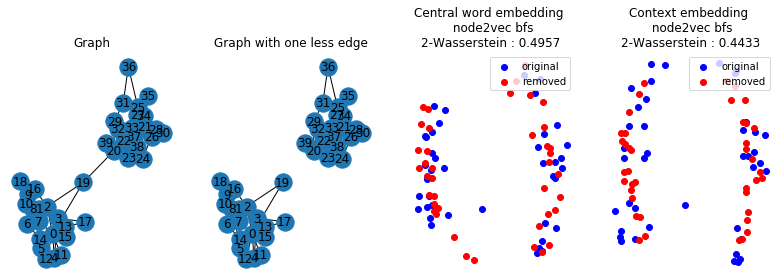

In [10]:
p = 3.0
q = 3.0

emb_word, emb_context = node2vec_embedding(G,
                                           p=p,
                                           q=q,
                                           k=EMBEDDING_SIZE,
                                           n_train=N_TRAIN,
                                           walk_length=WALK_LENGTH,
                                           window_size=WINDOW_SIZE,
                                           n_neg=N_NEG,
                                           hidden_size = HIDDEN_SIZE,
                                           use_cuda=USE_CUDA,
                                          )
emb_removed_word, emb_removed_context = node2vec_embedding(G_removed,
                                                           p=p,
                                                           q=q,
                                                           k=EMBEDDING_SIZE,
                                                           n_train=N_TRAIN,
                                                           walk_length=WALK_LENGTH,
                                                           window_size=WINDOW_SIZE,
                                                           n_neg=N_NEG,
                                                           hidden_size = HIDDEN_SIZE,
                                                           use_cuda=USE_CUDA,
                                                          )

# extract 2 principal components to plot
pca = PCA(n_components=2)
emb_word = pca.fit_transform(emb_word.cpu())
emb_context = pca.fit_transform(emb_context.cpu())
emb_removed_word = pca.fit_transform(emb_removed_word.cpu())
emb_removed_context = pca.fit_transform(emb_removed_context.cpu())

# plot the graph
fig, axes = plt.subplots(figsize=(11,4), nrows=1, ncols=4)

ax = axes[0]
nx.draw_networkx(G, pos = pos, ax=ax)
ax.set_title('Graph')
ax.axis('off')

ax = axes[1]
nx.draw_networkx(G_removed, pos = pos, ax=ax)
ax.set_title('Graph with one less edge')
ax.axis('off')

wass_word = wasserstein_metric(emb_word, emb_removed_word)
wass_context = wasserstein_metric(emb_context, emb_removed_context)

ax = axes[2]
ax.scatter(emb_word[:, 0], emb_word[:, 1], label='original', color='b')
ax.scatter(emb_removed_word[:, 0], emb_removed_word[:, 1], label='removed', color='r')
ax.set_title('Central word embedding \n node2vec bfs\n2-Wasserstein : {:.4f}'.format(wass_word))
ax.legend(loc='upper right')
ax.axis('off')

ax = axes[3]
ax.scatter(emb_context[:, 0], emb_context[:, 1], label='original', color='b')
ax.scatter(emb_removed_context[:, 0], emb_removed_context[:, 1], label='removed', color='r')
ax.set_title('Context embedding \n node2vec bfs\n2-Wasserstein : {:.4f}'.format(wass_context))
ax.legend(loc='upper right')
ax.axis('off')

plt.tight_layout()
plt.show()